# Task 4: Baseline with Count Vectorization

Useful links:

https://stackoverflow.com/questions/60195735/use-tf-idf-with-in-keras-model

https://www.kaggle.com/code/mikhailborovinskikh/tfidf-keras/notebook

https://www.kaggle.com/code/lonnieqin/tf-idf-vectorization-with-keras/notebook

In [1]:
import os
import pandas as pd
import nlp
import random
import string
import shutil
import nltk
import re
import pathlib
import spacy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


import keras

from collections import Counter
from nltk.corpus import stopwords
from tensorflow.keras import layers
from tensorflow.keras import losses
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
# Always clear as keras backend is tedious
tf.keras.backend.clear_session()

In [3]:
#gpu setup when using Tensorflow to address memory expansion/growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2022-04-23 11:33:25.174931: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 11:33:25.193220: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 11:33:25.193357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 11:33:25.194169: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

1 Physical GPUs, 1 Logical GPUs


2022-04-23 11:33:25.194646: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 11:33:25.194772: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 11:33:25.194881: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 11:33:25.457409: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 11:33:25.457550: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [4]:
working_path = pathlib.Path().resolve()
path_object = pathlib.Path(working_path)
parent_path = path_object.parent
data_path  = os.path.join(parent_path, "01-Data/PubMed_200k_RCT_numbers_replaced_with_at_sign/")

In [5]:
ps = PorterStemmer()
lm = WordNetLemmatizer()
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
STOPWORDS = set(stopwords.words('english'))

def stem_words(text):
    return " ".join([ps.stem(word) for word in text.split()])
def lemmatize_words(text):
    return " ".join([lm.lemmatize(word) for word in text.split()])
def remove_punctuation(text,punctuation_string):
    return text.translate(str.maketrans('', '', punctuation_string))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])                                 
def remove_freqwords(text,freqwords):
    return " ".join([word for word in str(text).split() if word not in freqwords])
def remove_rarewords(text,rarewords):
    return " ".join([word for word in str(text).split() if word not in rarewords])
maxlen=50
def get_sequences(df,maxlen=50):
    #sequences = tokenizer.texts_to_sequences(df.text.tolist())
    padded = pad_sequences(sequences, truncating = 'post', padding='post', maxlen=maxlen)
    return padded
def get_lines(filename):
    with open(filename, "r") as f:    
        return f.readlines()

[nltk_data] Downloading package stopwords to /home/flavia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/flavia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/flavia/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [6]:
def prepare_text(filename):
    """Returns a pandas dataframe.
    
    Reads filenames, its contents, seperates labels and text

    Args:
        filename

    Returns:
        pd.dataframe

    """
    input_lines = get_lines(filename)
    abstract_lines = "" 
    abstract_dict_list = [] 

    for line in input_lines:
        if line.startswith("###"): # check if new ID
            abstract_lines = "" #simple reset
        elif line.isspace(): # if new line?
            splitted_abstract_lines = abstract_lines.splitlines() # split abstract into separate lines
            for split_line in splitted_abstract_lines:
                abstract_dict = {} # create dict for easy df transfer
                split = split_line.split("\t") # split label from text with \t
                abstract_dict["label"] = split[0] # get label
                abstract_dict["text"]=split[1].lower()
                abstract_dict_list.append(abstract_dict)
        else: 
            abstract_lines += line
    df = pd.DataFrame(abstract_dict_list)

    #Remove punctuation
    punctuation_string = string.punctuation
    #punctuation_string = punctuation_string.replace('%', '')
    df["text_wo_punct"] = df["text"].apply(lambda text: remove_punctuation(text,punctuation_string))
    
    #Remove stopwords
    df["text_wo_stop"] = df["text_wo_punct"].apply(lambda text: remove_stopwords(text))
    
    #Remove most frequent words
    cnt = Counter()
    for text in df["text_wo_stop"].values:
        for word in text.split():
            cnt[word] += 1
    freqwords = set([w for (w, wc) in cnt.most_common(10)])
    df["text_wo_stopfreq"] = df["text_wo_stop"].apply(lambda text: remove_freqwords(text,freqwords))

    
    #Remove rarest words
    n_rare_words = 10
    rarewords = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
    df["text_wo_stopfreqrare"] = df["text_wo_stopfreq"].apply(lambda text: remove_rarewords(text,rarewords))

    #Stemming
    #df["text_stemmed"] = df["text_wo_stopfreqrare"].apply(lambda text: stem_words(text))
    #df["processed_text"] = df["text_wo_stopfreqrare"].apply(lambda text: stem_words(text))

    df["processed_text"] = df["text_wo_stopfreqrare"]
    
    return df

In [7]:
# Dataframes from preprocessing
df_train = prepare_text(data_path + "train.txt")
df_val   = prepare_text(data_path + "dev.txt")
df_test  = prepare_text(data_path + "test.txt")

In [8]:
#Helper dicts with relationships and inverse relationships
classes = set(df_train.label.tolist())
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v,k) for k, v in class_to_index.items())
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [9]:
X_train = df_train["processed_text"]
X_val = df_val["processed_text"]
X_test = df_test["processed_text"]

text_vectorizer = layers.TextVectorization(max_tokens=10000, output_mode="count", ngrams=2)

# Index the bigrams and learn the TF-IDF weights via `adapt()`
with tf.device("CPU"):
    # A bug that prevents this from running on GPU for now.
    text_vectorizer.adapt(X_train)

In [10]:
#to single digit label
Y_train = names_to_ids(df_train.label.tolist())
Y_val   = names_to_ids(df_val.label.tolist())
Y_test  = names_to_ids(df_test.label.tolist())

In [11]:
model = keras.Sequential([
        keras.Input(shape=(), dtype="string"),
        text_vectorizer,
        layers.Dense(256, activation="relu", kernel_regularizer="l2"),
        layers.Dense(32, activation="relu", kernel_regularizer="l2"),
        layers.Dense(5, activation="sigmoid")
    ])
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 10000)            0         
 torization)                                                     
                                                                 
 dense (Dense)               (None, 256)               2560256   
                                                                 
 dense_1 (Dense)             (None, 32)                8224      
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 2,568,645
Trainable params: 2,568,645
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,
    batch_size=256,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)]
    )

Epoch 1/20
   1/8641 [..............................] - ETA: 2:29:26 - loss: 7.1499 - accuracy: 0.1797

2022-04-23 11:42:46.259869: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


8641/8641 [==============================] - 76s 9ms/step - loss: 0.9668 - accuracy: 0.7100 - val_loss: 0.8540 - val_accuracy: 0.7263
Epoch 2/20
8641/8641 [==============================] - 75s 9ms/step - loss: 0.8252 - accuracy: 0.7377 - val_loss: 0.8078 - val_accuracy: 0.7365
Epoch 3/20
8641/8641 [==============================] - 74s 9ms/step - loss: 0.7945 - accuracy: 0.7465 - val_loss: 0.7750 - val_accuracy: 0.7504
Epoch 4/20
8641/8641 [==============================] - 75s 9ms/step - loss: 0.7814 - accuracy: 0.7551 - val_loss: 0.7638 - val_accuracy: 0.7588
Epoch 5/20
8641/8641 [==============================] - 76s 9ms/step - loss: 0.7729 - accuracy: 0.7580 - val_loss: 0.7633 - val_accuracy: 0.7602
Epoch 6/20
8641/8641 [==============================] - 76s 9ms/step - loss: 0.7686 - accuracy: 0.7584 - val_loss: 0.7572 - val_accuracy: 0.7596
Epoch 7/20
8641/8641 [==============================] - 76s 9ms/step - loss: 0.7656 - accuracy: 0.7586 - val_loss: 0.7596 - val_accuracy: 0.7

In [13]:
model.evaluate(X_test, Y_test)

922/922 [==============================] - 2s 2ms/step - loss: 0.7529 - accuracy: 0.7584


[0.7528541088104248, 0.7584172487258911]

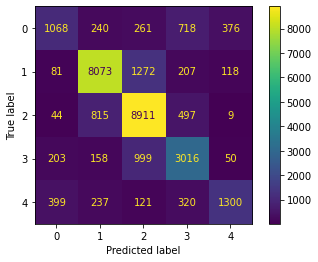

In [14]:
pred_vals = model.predict(X_test)
pred_vals = np.argmax(pred_vals, axis=1)
confma = confusion_matrix(Y_test, pred_vals, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=confma)
disp.plot()

In [15]:
f1 = f1_score(Y_test, pred_vals, average="weighted")

print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_vals)

print("Test accuracy score : %s "% acc)

Test f1 score : 0.7526510281294575 
Test accuracy score : 0.7584172515512155 


Scores for regular 200k dataset
Test f1 score : 0.7461742303206325 
Test accuracy score : 0.7522123893805309 


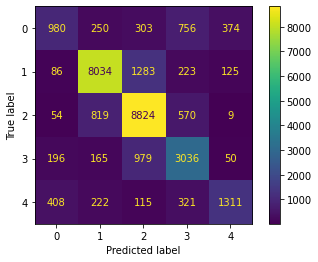

In [20]:
# 200k data

print("Scores for regular 200k dataset")

df200k_test  = prepare_text("../01-Data/PubMed_200k_RCT/" + "test.txt")
X200k_test = df200k_test["processed_text"]
Y200k_test  = names_to_ids(df200k_test.label.tolist())

pred_vals_200k = model.predict(X200k_test)
pred_vals_200k = np.argmax(pred_vals_200k, axis=1)

confma = confusion_matrix(Y200k_test, pred_vals_200k, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=confma)
disp.plot()

f1 = f1_score(Y200k_test, pred_vals_200k, average="weighted")

print("Test f1 score : %s "% f1)

acc = accuracy_score(Y200k_test, pred_vals_200k)

print("Test accuracy score : %s "% acc)

In [18]:
model.save_weights('../04-Models/count_model_1.tf')

print("saved")

saved
